In [2]:
import numpy as np

### Creating your own GRN

# Generate the cell lineage first

In [123]:
#!/usr/bin/env python3

import random
import time

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def get_adjacency_matrix(G):
    return nx.to_numpy_array(G, dtype=int)

def generate_random_cell_cycle(total_nodes=None,
                               min_per_rank=2,
                               max_per_rank=3,
                               min_ranks=1,
                               max_ranks=5,
                               percent=0,
                               master_regulators=0):
    """
    Generate a DAG where each node has exactly one parent:
      - If total_nodes is set, pick `master_regulators` to exclude,
        then for each remaining node choose exactly one parent:
          * with `percent`% chance, pick any previous node;
          * otherwise, pick from the forced scheme.
      - Otherwise, build in layers: for rank-based,
          * first rank: chain nodes so each has one parent;
          * subsequent ranks: for each node, with `percent`% chance pick any existing node,
            else pick one from previous rank.
    """
    random.seed(time.time())
    G = nx.DiGraph()

    # Fixed-N mode
    if total_nodes is not None:
        all_indices = list(range(total_nodes))
        mr_indices = sorted(random.sample(all_indices, master_regulators)) if master_regulators > 0 else []
        dag_indices = [i for i in all_indices if i not in mr_indices]

        G.add_nodes_from(dag_indices)
        for idx, node in enumerate(dag_indices[1:], start=1):
            # decide parent
            if random.randint(0, 99) < percent:
                parent = random.choice(dag_indices[:idx])
            else:
                parent = dag_indices[random.randint(0, idx - 1)]
            G.add_edge(parent, node)
        return G, mr_indices

    # Rank-based mode
    nodes = 0
    ranks = random.randint(min_ranks, max_ranks)
    all_ranks = []
    for _ in range(ranks):
        new_nodes = random.randint(min_per_rank, max_per_rank)
        current_rank = list(range(nodes, nodes + new_nodes))
        G.add_nodes_from(current_rank)

        if not all_ranks:
            # first rank: chain
            for i in range(1, len(current_rank)):
                if random.randint(0, 99) < percent:
                    # pick any previous (only itself chain so use previous)
                    parent = current_rank[i-1]
                else:
                    parent = current_rank[i-1]
                G.add_edge(parent, current_rank[i])
        else:
            prev = all_ranks[-1]
            for node in current_rank:
                if random.randint(0, 99) < percent:
                    parent = random.randint(0, nodes-1)
                    G.add_edge(parent, node)
                else:
                    parent = random.choice(prev)
                    G.add_edge(parent, node)

        nodes += new_nodes
        all_ranks.append(current_rank)

    return G, []

def visualize_dag(G, interactions=None):
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)

    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
    nx.draw_networkx_labels(G, pos, font_size=10)

    if interactions is None:
        nx.draw_networkx_edges(
            G, pos, edge_color='gray',
            arrows=True, arrowstyle='-|>', arrowsize=20, width=1.5
        )
    else:
        edge_list = [(a, t) for (t, _, a, _, _) in interactions]
        colors    = ['red' if mag < 0 else 'green' for (_, _, _, mag, _) in interactions]
        nx.draw_networkx_edges(
            G, pos,
            edgelist=edge_list, edge_color=colors,
            arrows=True, arrowstyle='-|>', arrowsize=20, width=2
        )

    plt.title("Randomly Generated DAG")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def perturb_adjacency_matrix(matrix, min_val=0.8, max_val=1.0):
    perturbed = matrix.astype(float).copy()
    ones = np.where(matrix == 1)
    for i, j in zip(*ones):
        perturbed[i, j] = round(random.uniform(min_val, max_val), 1)
    return perturbed

def find_isolated_nodes(G):
    return [n for n in G.nodes() if G.in_degree(n)==0 and G.out_degree(n)==0]

def generate_interactions_from_dag(G,
                                   scalar=2.0,
                                   mag_range=(0.5,5.0),
                                   inhibit_pct=50):
    interactions = []
    for u, v in G.edges():
        mag = round(random.uniform(*mag_range), 2)
        mag = -abs(mag) if random.randint(1,100) <= inhibit_pct else abs(mag)
        interactions.append((v, 1, u, mag, scalar))
    return interactions

def main(mode,
         total_nodes=None,
         min_per_rank=2,
         max_per_rank=3,
         min_ranks=1,
         max_ranks=5,
         percent=0,
         inhibit_pct=50,
         master_regulators=0,
         num_celltypes=3):
    dag, mr_indices = generate_random_cell_cycle(
        total_nodes,
        min_per_rank,
        max_per_rank,
        min_ranks,
        max_ranks,
        percent,
        master_regulators
    )

    interactions = generate_interactions_from_dag(dag, inhibit_pct=inhibit_pct)
    visualize_dag(dag, interactions if mode=='gene' else None)

    iso = find_isolated_nodes(dag)
    print("Isolated Nodes:", iso)

    if mode=='cell':
        matrix = get_adjacency_matrix(dag)
        print("\nAdjacency Matrix:")
        for row in matrix:
            print("\t".join('0' if v==0 else str(v) for v in row))

        perturbed = perturb_adjacency_matrix(matrix)
        print("\nPerturbed Adjacency Matrix:")
        for row in perturbed:
            print("\t".join('0' if v==0 else str(v) for v in row))

        with open("perturbed_matrix.tab","w") as f:
            for row in perturbed:
                f.write("\t".join('0' if v==0 else str(v) for v in row) + "\n")
        print("\nPerturbed matrix written to perturbed_matrix.tab")

    elif mode=='gene':
        affs   = {a for (_,_,a,_,_) in interactions}
        targs  = {t for (t,_,_,_,_) in interactions}
        aff_only = sorted(affs - targs)
        all_mr   = sorted(set(mr_indices) | set(aff_only))

        with open("gene_interactions.txt","w") as f:
            for t,typ,a,mag,sc in interactions:
                f.write(f"{t},{typ},{a},{mag},{sc}\n")
        print("\nGene interactions written to gene_interactions.txt")

        if all_mr:
            print("\nMaster Regulator Profiles:")
            with open("master_regulators.txt","w") as f:
                
                for idx in all_mr:
                    expr = [round(random.uniform(0.0,4.0),4) for _ in range(num_celltypes)]
                    line = f"{idx}," + ",".join(map(str, expr))
                    print(line)
                    f.write(line+"\n")
            print("\nMaster regulators written to master_regulators.txt")

    else:
        raise ValueError("Mode must be 'cell' or 'gene'")

# Example usage:
# main('cell', total_nodes=5, percent=20)
# main('gene', total_nodes=10, master_regulators=2, inhibit_pct=60, num_celltypes=4)


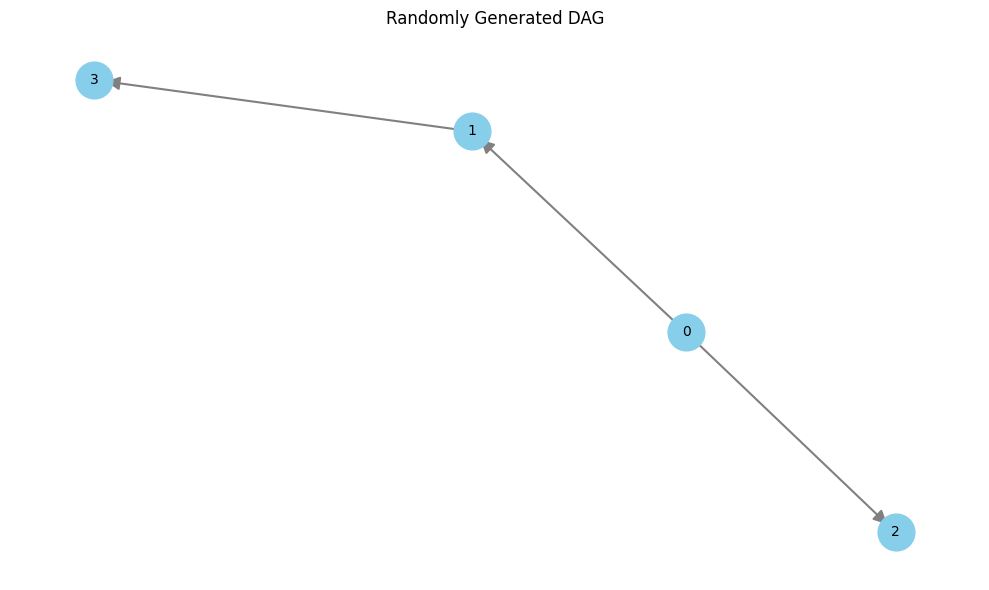

Isolated Nodes: []

Adjacency Matrix:
0	1	1	0
0	0	0	1
0	0	0	0
0	0	0	0

Perturbed Adjacency Matrix:
0	0.9	0.9	0
0	0	0	0.8
0	0	0	0
0	0	0	0

Perturbed matrix written to perturbed_matrix.tab


In [125]:
# import this module, then:
main('cell', total_nodes=4, min_per_rank=1, max_per_rank=4, min_ranks=1, max_ranks=3)


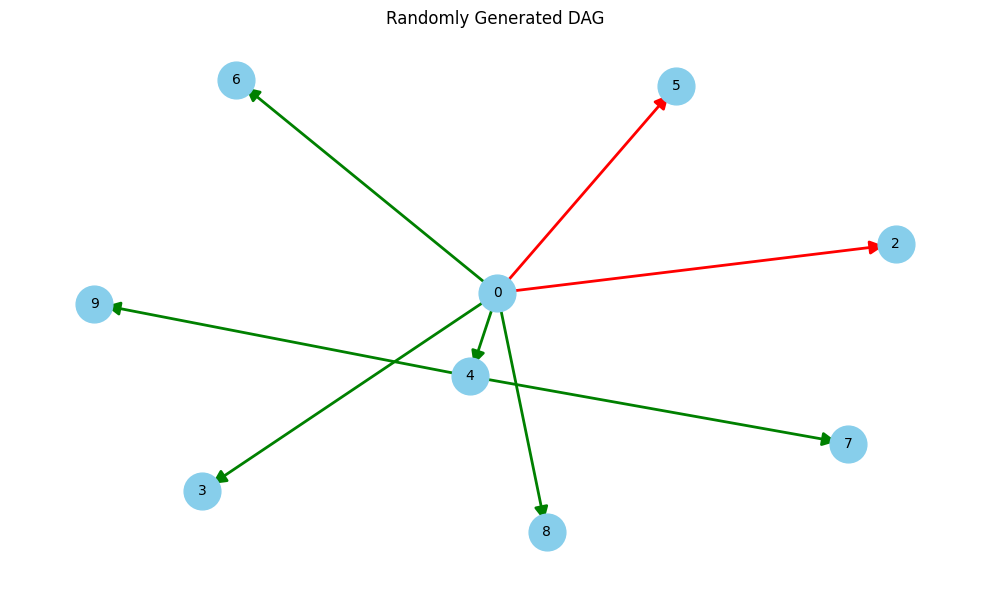

Isolated Nodes: []

Gene interactions written to gene_interactions.txt

Master Regulator Profiles:
0,0.9447,1.3862,2.6614,0.5823
1,2.2842,2.4169,1.5496,3.6247

Master regulators written to master_regulators.txt


In [124]:
main('gene', total_nodes=10, min_per_rank=2, max_per_rank=3, min_ranks=1, max_ranks=2, percent=5, inhibit_pct=30, master_regulators=1, num_celltypes=4)